In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score, f1_score, precision_score
from sklearn.utils.class_weight import compute_class_weight

from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
%matplotlib inline

from prettytable import PrettyTable

In [ ]:
# Specify GPU
device = torch.device("cuda")

In [ ]:
# Change to your own directory
try:
    os.chdir("/content/gdrive/MyDrive/Suicide_Detection/")
    print("Directory changed")
except OSError:
    print("Error: Can't change the Current Working Directory")

Directory changed


In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# Load dataset
df = pd.read_csv('reddit_suicide_detection_final_clean.csv', header=0)
df.drop(columns=['text'], axis=1, inplace=True)
df = df.rename(columns={"cleaned_text": "text"})
classes = {"suicide": 1, "non-suicide": 0}
df = df.replace({"class": classes})
df = df[df['text'].notnull()]
df

,class,text
0,1,sex wife threaten suicide recently leave wife ...
1,0,weird not affect compliment come know girl but...
2,0,finally never hear bad year swear fucking god ...
3,1,need help help cry hard
4,1,end tonight not anymore quit
...,...,...
174170,0,today went sled friend not like but pretty big...
174171,0,not like rock not go but
174172,0,tell friend not lonely deprive buy little nigh...
174173,0,pee probably taste like salty tea drink pee co...


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Encode the labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['class'])

In [ ]:
# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])

In [ ]:
# Pad the sequences to have uniform length
max_sequence_length = max(len(x) for x in sequences)
X = pad_sequences(sequences, maxlen=max_sequence_length)

In [ ]:
# Labels
y = df['label'].values

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Vocabulary size for embedding layer
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
from gensim.models import Word2Vec

# Assuming `sequences` is a list of lists where each sub-list is a sequence of tokens corresponding to a sentence
words = [[tokenizer.index_word[i] for i in seq if i != 0] for seq in sequences]

In [ ]:
# Train a Word2Vec model
word_vectors = Word2Vec(sentences=words, vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
# Create an embedding matrix
embedding_matrix = np.zeros((vocab_size, 100)) # Assuming 100 dimensions for the Word2Vec vectors
for word, i in tokenizer.word_index.items():
    if word in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[word]

# Model 1

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model1 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, input_length=max_sequence_length, trainable=False),
    LSTM(units=128, return_sequences=True),
    Dropout(0.2),
    LSTM(units=64),
    Dropout(0.2),
    Dense(units=32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 64, 100)           2957600   
                                                                 
 lstm_4 (LSTM)               (None, 64, 128)           117248    
                                                                 
 dropout_4 (Dropout)         (None, 64, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                

In [ ]:
# Train the model
history1 = model1.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
1741/1741 [==============================] - 22s 10ms/step - loss: 0.4452 - accuracy: 0.8018 - f1_m: 0.7163 - precision_m: 0.7763 - recall_m: 0.6799 - val_loss: 0.3976 - val_accuracy: 0.8344 - val_f1_m: 0.7566 - val_precision_m: 0.8571 - val_recall_m: 0.6843
Epoch 2/10
1741/1741 [==============================] - 17s 10ms/step - loss: 0.3661 - accuracy: 0.8476 - f1_m: 0.7891 - precision_m: 0.8331 - recall_m: 0.7591 - val_loss: 0.3362 - val_accuracy: 0.8616 - val_f1_m: 0.8124 - val_precision_m: 0.8381 - val_recall_m: 0.7947
Epoch 3/10
1741/1741 [==============================] - 17s 9ms/step - loss: 0.3275 - accuracy: 0.8679 - f1_m: 0.8187 - precision_m: 0.8541 - recall_m: 0.7936 - val_loss: 0.3153 - val_accuracy: 0.8739 - val_f1_m: 0.8309 - val_precision_m: 0.8459 - val_recall_m: 0.8224
Epoch 4/10
1741/1741 [==============================] - 17s 10ms/step - loss: 0.3080 - accuracy: 0.8771 - f1_m: 0.8321 - precision_m: 0.8632 - recall_m: 0.8103 - val_loss: 0.3097 - val_accura

In [ ]:
# Evaluate the model
test_loss1, test_acc1, test_f1score1, test_precision1, test_recall1 = model1.evaluate(X_test, y_test)
print(f"Test Accuracy for LSTM Model without pretrained embeddings: {test_acc1}")

1088/1088 [==============================] - 5s 4ms/step - loss: 0.2589 - accuracy: 0.8984 - f1_m: 0.8609 - precision_m: 0.8775 - recall_m: 0.8548
Test Accuracy for LSTM Model without pretrained embeddings: 0.898411214351654


# Model 2

In [ ]:
model2 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False),
    LSTM(units=128, return_sequences=True),
    Dropout(0.2),
    LSTM(units=64),
    Dropout(0.2),
    Dense(units=32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 64, 100)           2957600   
                                                                 
 lstm_6 (LSTM)               (None, 64, 128)           117248    
                                                                 
 dropout_6 (Dropout)         (None, 64, 128)           0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                

In [ ]:
# Train the model
history2 = model2.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
1741/1741 [==============================] - 21s 10ms/step - loss: 0.2204 - accuracy: 0.9154 - f1_m: 0.8871 - precision_m: 0.8944 - recall_m: 0.8858 - val_loss: 0.1945 - val_accuracy: 0.9260 - val_f1_m: 0.9017 - val_precision_m: 0.9075 - val_recall_m: 0.8996
Epoch 2/10
1741/1741 [==============================] - 16s 9ms/step - loss: 0.1908 - accuracy: 0.9270 - f1_m: 0.9025 - precision_m: 0.9088 - recall_m: 0.9005 - val_loss: 0.1895 - val_accuracy: 0.9282 - val_f1_m: 0.9065 - val_precision_m: 0.8920 - val_recall_m: 0.9250
Epoch 3/10
1741/1741 [==============================] - 17s 9ms/step - loss: 0.1774 - accuracy: 0.9323 - f1_m: 0.9101 - precision_m: 0.9152 - recall_m: 0.9086 - val_loss: 0.1830 - val_accuracy: 0.9309 - val_f1_m: 0.9062 - val_precision_m: 0.9251 - val_recall_m: 0.8919
Epoch 4/10
1741/1741 [==============================] - 16s 9ms/step - loss: 0.1641 - accuracy: 0.9375 - f1_m: 0.9170 - precision_m: 0.9223 - recall_m: 0.9152 - val_loss: 0.1881 - val_accuracy

In [ ]:
# Evaluate the model
test_loss2, test_acc2, test_f1score2, test_precision2, test_recall2 = model2.evaluate(X_test, y_test)
print(f"Test Accuracy for LSTM Model with customized Word2Vec embeddings: {test_acc2}")

1088/1088 [==============================] - 5s 4ms/step - loss: 0.2699 - accuracy: 0.9225 - f1_m: 0.8957 - precision_m: 0.8938 - recall_m: 0.9055
Test Accuracy for LSTM Model with customized Word2Vec embeddings: 0.9225443005561829


In [ ]:
table = PrettyTable()
table.field_names = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score']

table.add_row(['LSTM without pre trained embedding weights',
               format(test_acc1, '.4f'),
               format(test_precision1, '.4f'),
               format(test_recall1, '.4f'),
               format(test_f1score1, '.4f')])

table.add_row(['LSTM with Word2Vec pre trained embedding weights',
               format(test_acc2, '.4f'),
               format(test_precision2, '.4f'),
               format(test_recall2, '.4f'),
               format(test_f1score2, '.4f')])

print(table)

+-------------------------------------------------+----------+-----------+--------+----------+
|                      Model                      | Accuracy | Precision | Recall | F1 Score |
+-------------------------------------------------+----------+-----------+--------+----------+
|    CNN without pre trained embedding weights    |  0.8984  |   0.8775  | 0.8548 |  0.8609  |
| CNN with Word2Vec pre trained embedding weights |  0.9225  |   0.8938  | 0.9055 |  0.8957  |
+-------------------------------------------------+----------+-----------+--------+----------+


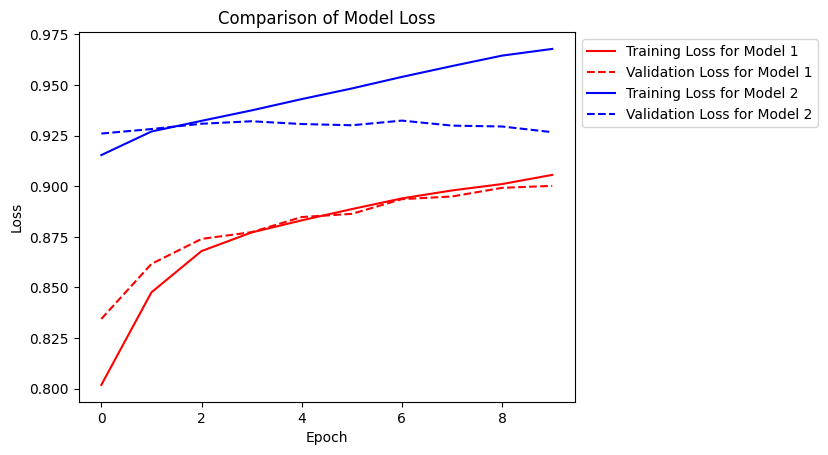

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values for Model 1
plt.plot(history1.history['accuracy'], 'r-')
plt.plot(history1.history['val_accuracy'], 'r--')
# Plot training & validation accuracy values for Model 2
plt.plot(history2.history['accuracy'], 'b-')
plt.plot(history2.history['val_accuracy'], 'b--')
plt.title('Comparison of Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

#plt.xlim(-0.5, 10)
#plt.xticks(np.arange(-0.5, 5, 0.1))
plt.legend(['Training Loss for Model 1', 'Validation Loss for Model 1', 'Training Loss for Model 2', 'Validation Loss for Model 2'], bbox_to_anchor=(1, 1))
plt.show()